In [76]:
import pandas as pd
import plotnine as pn
import numpy as np

from tqdm import tqdm

In [77]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,41.100833,0.679679,109,1.333333,False,1ccf300b3f4965f831a41232ba4b7c0c3c90d929,2020,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
1,38.076275,0.721620,88,44.818182,False,1d4e43c1be145f6711ec00af900a8658d82623a0,2012,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
2,41.553209,0.708944,69,5.125000,False,16e772e28b3470cb0050328c6e5a500882ff15ae,2015,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
3,30.062907,0.686039,179,0.000000,False,0bc5bf8a556f158b1bdaada28ce9cbd28c5d55a4,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
4,39.494263,0.681023,55,1.500000,False,35d7b77f2a6436124346d80aabc4bd66d5e0bd8b,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
149972,41.647954,0.646499,11,1.300000,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
149973,35.738649,0.708053,15,1.937500,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics
149974,181.720839,0.733839,8,2.435897,False,aa87aea86277064807b2a5123456c36a07db9164,1984,S2,SciBERT,Andre2018,Mathematics
149975,34.624962,0.677309,16,0.000000,False,7eef2cd2385ebf010af1f5eae1a6b58dedfd650d,2021,S2,SciBERT,Andre2018,Mathematics


In [78]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [79]:
# df = df_all[df_all["citations_per_year"] > 0]
df = df_all[df_all["density"] < 100] # hacky
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/92397243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/92397243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 100) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    log_cpy_bins = df[["log_cpy", "density_bin"]]    

    ents = [
        entropy_estimator(
            observations=log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # just look at variance for now
    variances = [
            np.nanvar(
            log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(
            bins, 
            df.density_bin.value_counts(sort=False, normalize=True), 
            df.density_bin.value_counts(sort=False, normalize=False),
            ents, 
            variances,
            ),
        columns=[
            "density_bin", 
            "freq", 
            "count", 
            "log_cpy entropy", 
            "log_cpy variance",
        ],
    )
    df_ent["field"] = field

    return df_ent


In [123]:
# Zach's algo

def get_df_var(df_in: pd.DataFrame, field: str, num_bins = 100) -> pd.DataFrame:
    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    log_cpy_bins = df[["log_cpy", "density_bin"]]
    
   # just look at variance for now
    variances = [
            np.nanvar(
            log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    n_bin = 200 # play with this

    d_bins = df.density_bin.unique()
    data = []

    for d_bin in d_bins:
        df_bin: pd.DataFrame = df[df["density_bin"] == d_bin]
        n_in_density_bin = len(df_bin)
        n_steps = int(n_in_density_bin / n_bin)

        for step in range(0, n_steps, n_bin):
            data_sorted_by_cpy = df_bin.sort_values("citations_per_year")
            
            data_to_bin = data_sorted_by_cpy[step: step + n_bin]

            var_cpy_in_density_bin = np.nanvar(data_to_bin["citations_per_year"])
            var_log_cpy_in_density_bin = np.nanvar(data_to_bin["log_cpy"])

            median_density_in_density_bin = np.nanmedian(data_to_bin["density"])
            median_cpy_in_density_bin = np.nanmedian(data_to_bin["citations_per_year"])
            median_log_cpy_in_density_bin = np.nanmedian(data_to_bin["log_cpy"])

            data.append(
                (
                    median_density_in_density_bin, 
                    median_cpy_in_density_bin,
                    median_log_cpy_in_density_bin,
                    var_cpy_in_density_bin,
                    var_log_cpy_in_density_bin,
                    field,
                )
            )
    
    return pd.DataFrame(
        data,
        columns=[
            "density_med_bin", 
            "cpy_med_bin", 
            "log_cpy_med_bin",
            "cpy_var",
            "log_cpy_var", 
            "field",
        ],
    )


get_df_var(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/3021625068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,density_med_bin,cpy_med_bin,log_cpy_med_bin,cpy_var,log_cpy_var,field
0,41.191661,1.639610,0.245411,0.810233,0.076700,Physics
1,37.951555,1.500000,0.221849,1.083753,0.100013,Physics
2,41.571340,1.750000,0.259637,0.960926,0.074319,Physics
3,39.393886,1.297059,0.153685,0.840823,0.128825,Physics
4,43.738409,2.133929,0.342423,1.532774,0.106143,Physics
5,39.027833,1.833333,0.278754,1.108630,0.131143,Physics
6,44.095920,1.849624,0.282547,1.440824,0.107210,Physics
7,38.299396,1.707265,0.251891,1.111380,0.084510,Physics
8,39.756354,1.542484,0.221849,0.891576,0.103223,Physics
9,43.372929,2.105556,0.342423,1.480739,0.070880,Physics


#### New scatterplot with trendlines

Why are the trends so robustly U-shaped?

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/3021625068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/3021625068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/3021625068.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/3021625068.py:8: SettingWithCopyWarning: 
A value is trying t

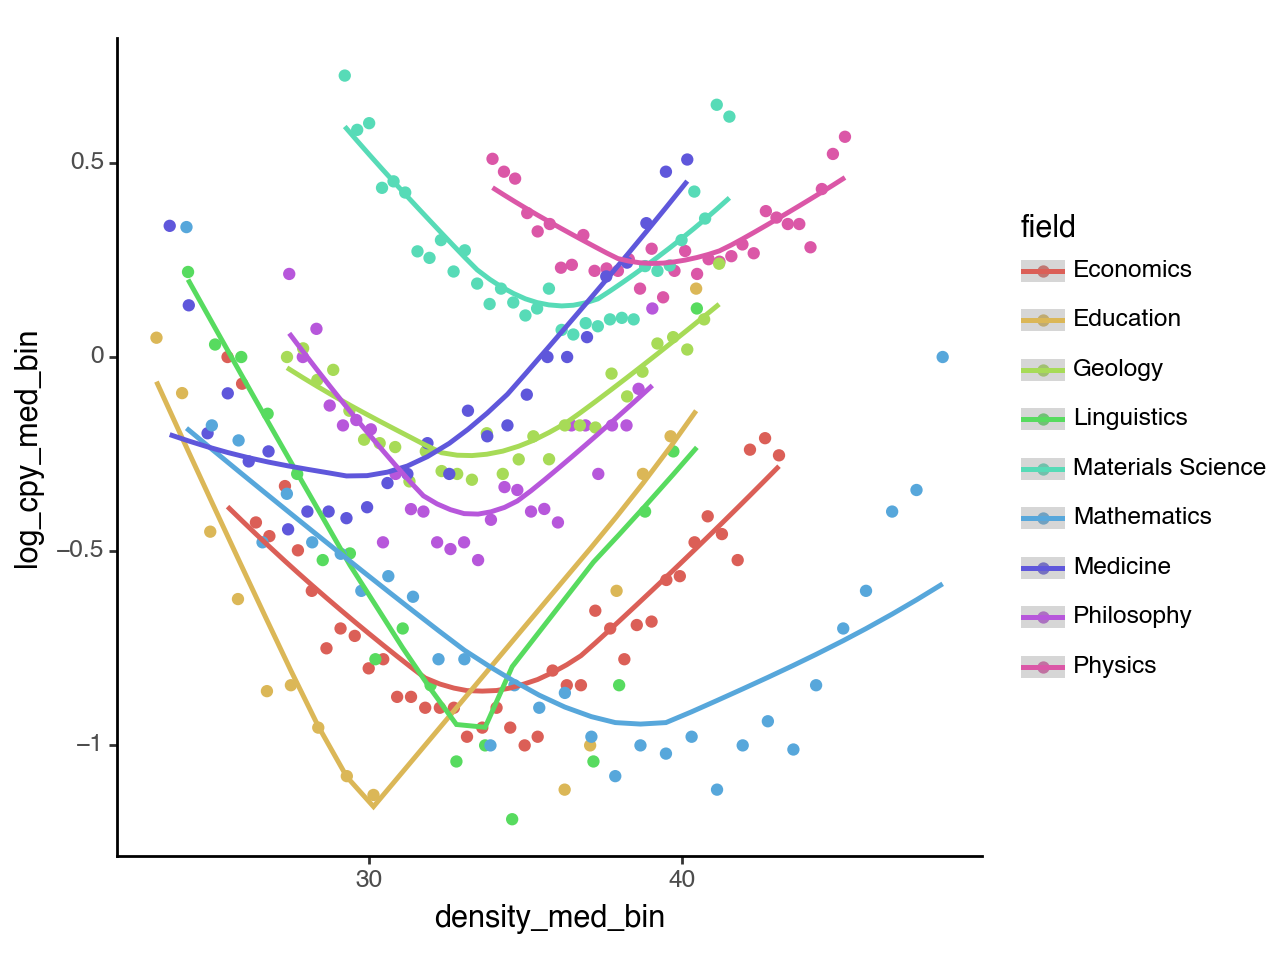

<Figure Size: (640 x 480)>

In [125]:
(
    pn.ggplot(
        pd.concat(
        [get_df_var(df, field)
        for field in df["fields_of_study_0"].unique()],
        ),
        pn.aes(
            x="density_med_bin",
            y="log_cpy_med_bin",
            # y="log_cpy_var",
            # y="cpy_var",
            color="field",
            # shape="field",
        )
    )
    # + pn.facet_wrap("field")
    + pn.geom_point(
        pn.aes(
            
        )
    )
    + pn.geom_smooth(
        pn.aes(
            color="field",
        )
    )
    # + pn.ylab("Variance in citations per year")
    # + pn.xlab("Prior density of neighborhood")
    + pn.theme_classic()
    # + pn.ylim(0,2)
)

In [37]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/583056898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,density_bin,freq,count,log_cpy entropy,log_cpy variance,field
0,15.983,0.000137,2,-0.0,0.026422,Physics
1,16.346,0.000343,5,NaN,0.000335,Physics
2,16.709,0.000685,10,NaN,0.155380,Physics
3,17.072,0.000343,5,NaN,1.048072,Physics
4,17.435,0.000754,11,NaN,0.595170,Physics
...,...,...,...,...,...,...
95,50.457,0.000822,12,NaN,0.171584,Physics
96,50.820,0.000480,7,NaN,0.209556,Physics
97,51.183,0.000206,3,-0.0,0.043945,Physics
98,51.546,0.000343,5,NaN,0.122696,Physics


In [38]:
df_ent_all = pd.concat(
    [get_df_ent(df, field)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/583056898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/583056898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/583056898.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_97914/583056898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,density_bin,freq,count,log_cpy entropy,log_cpy variance,field
0,15.983,0.000137,2,-0.00000,0.026422,Physics
1,16.346,0.000343,5,NaN,0.000335,Physics
2,16.709,0.000685,10,NaN,0.155380,Physics
3,17.072,0.000343,5,NaN,1.048072,Physics
4,17.435,0.000754,11,NaN,0.595170,Physics
...,...,...,...,...,...,...
95,89.806,0.000000,0,NaN,NaN,Mathematics
96,90.611,0.000056,1,NaN,0.000000,Mathematics
97,91.416,0.000000,0,NaN,NaN,Mathematics
98,92.222,0.000000,0,NaN,NaN,Mathematics


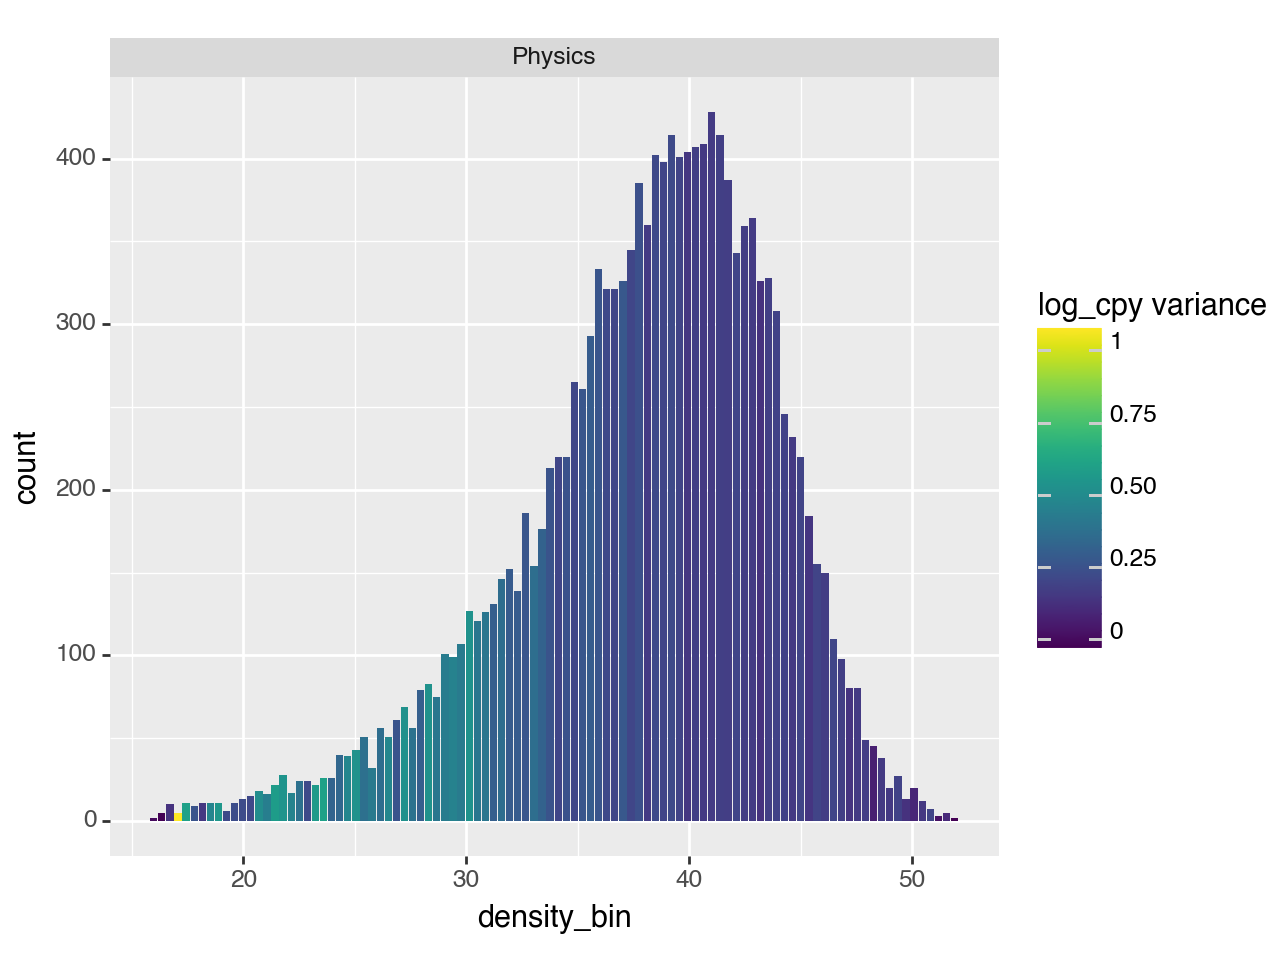

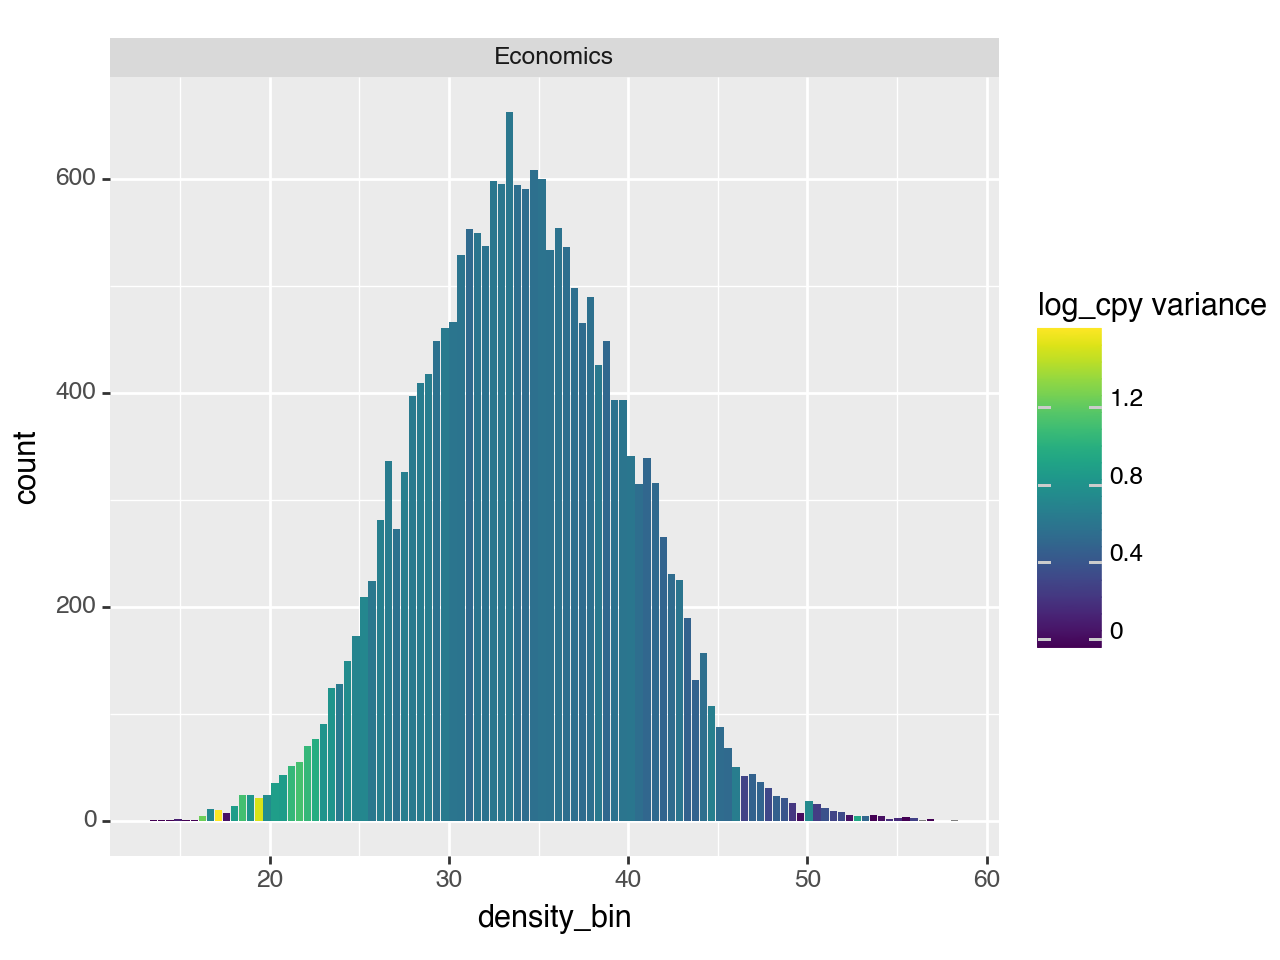

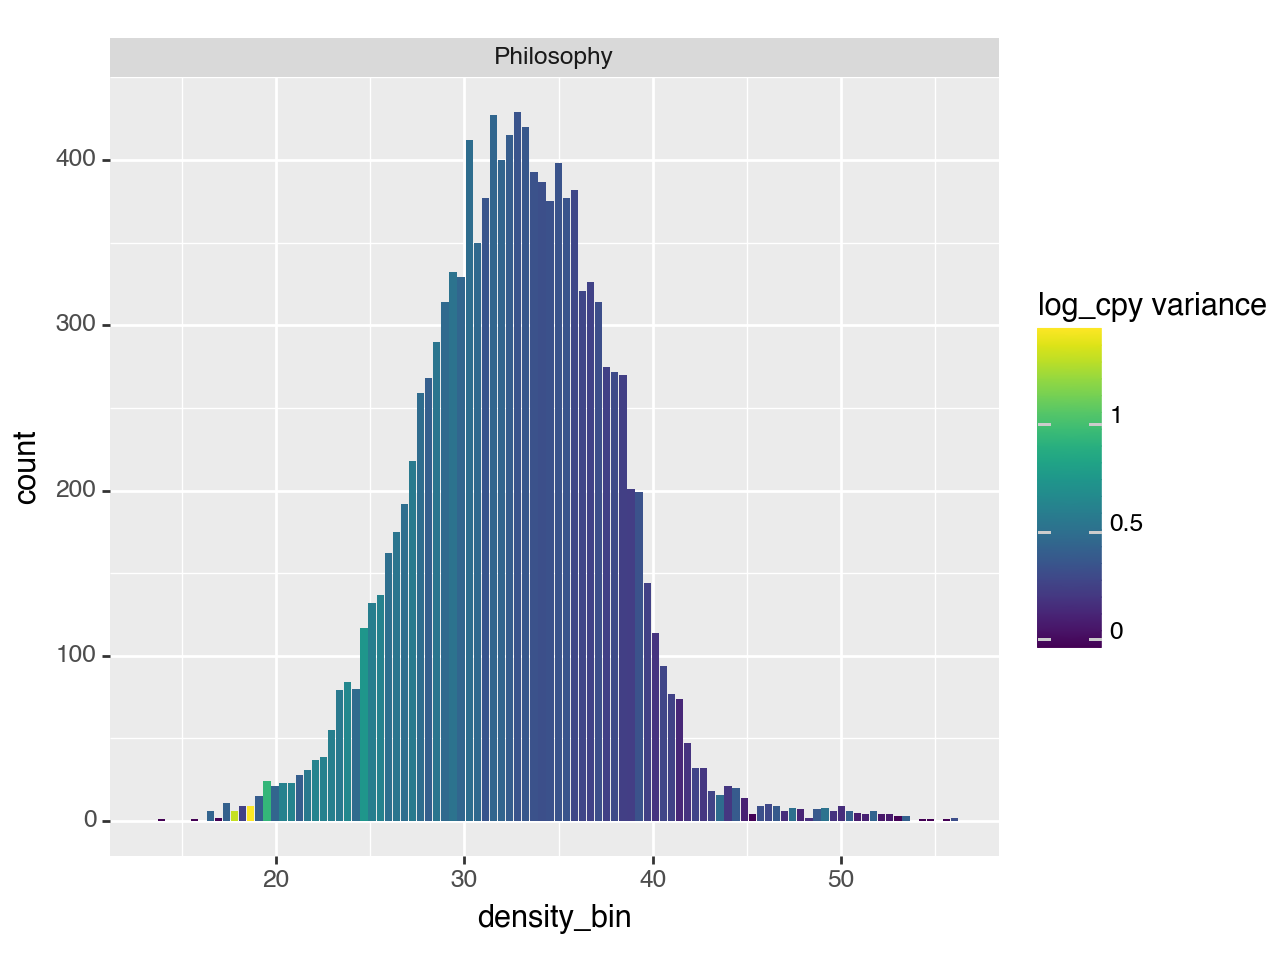

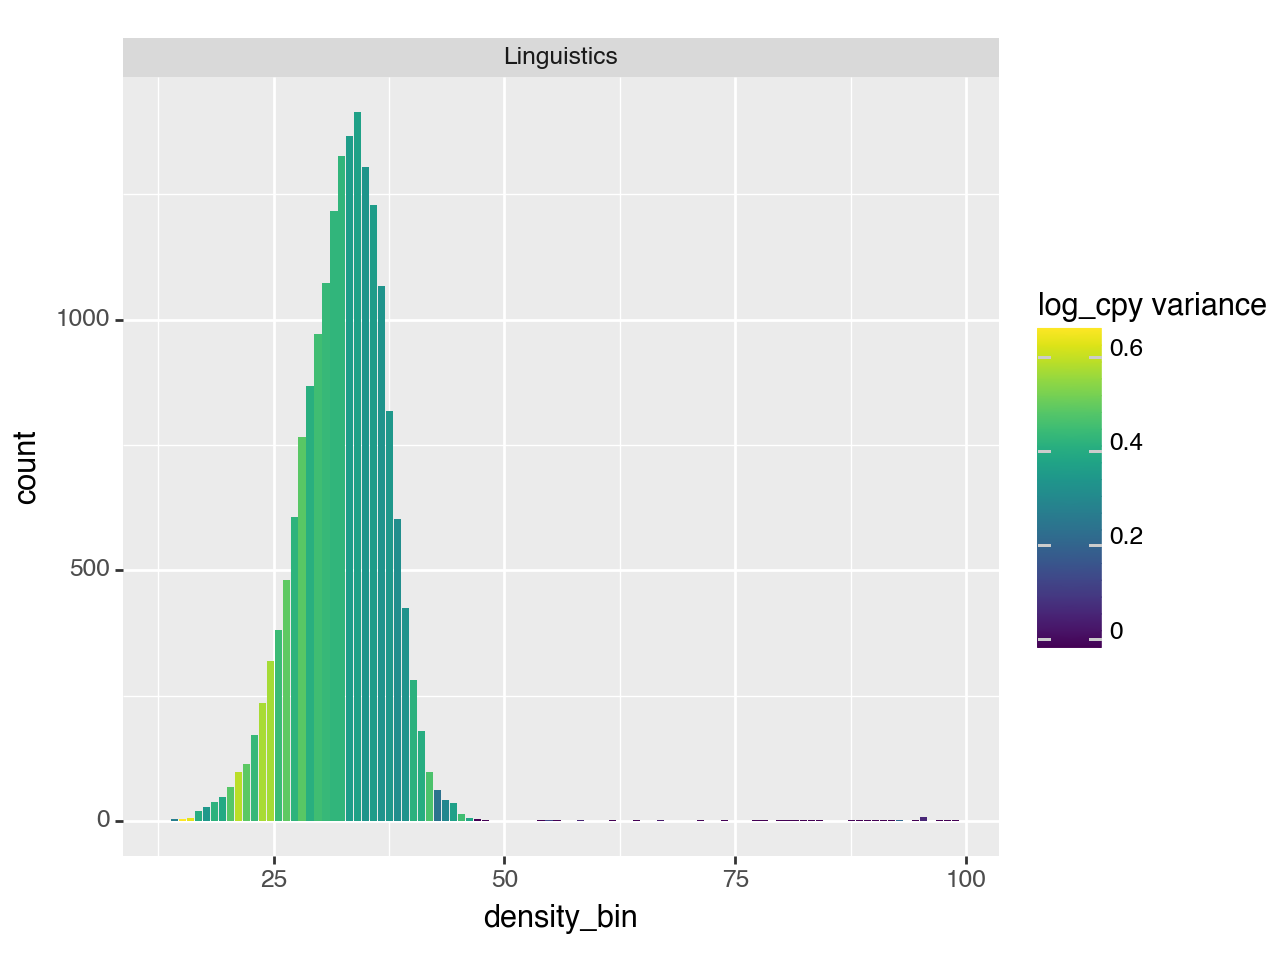

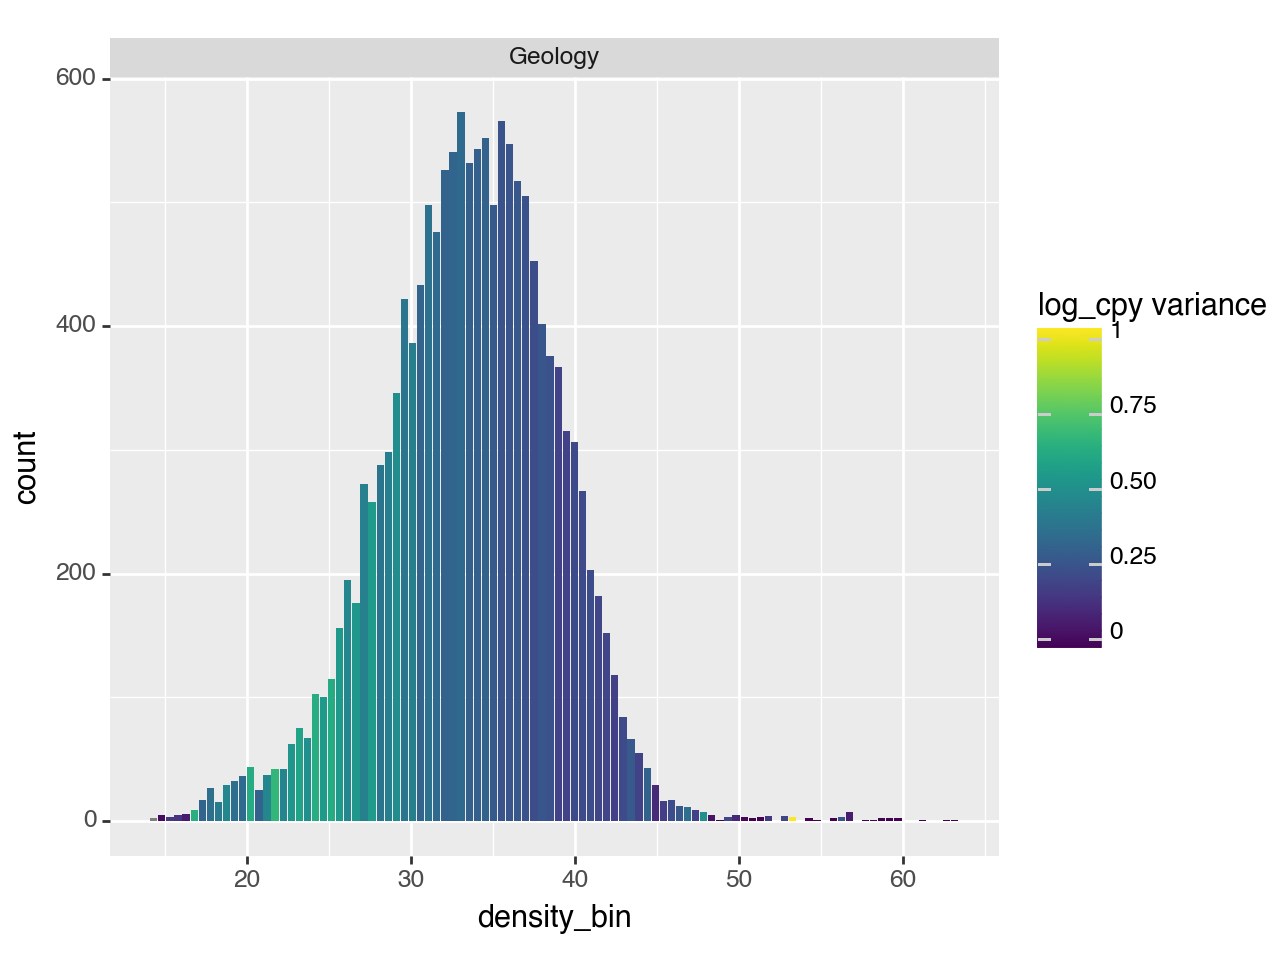

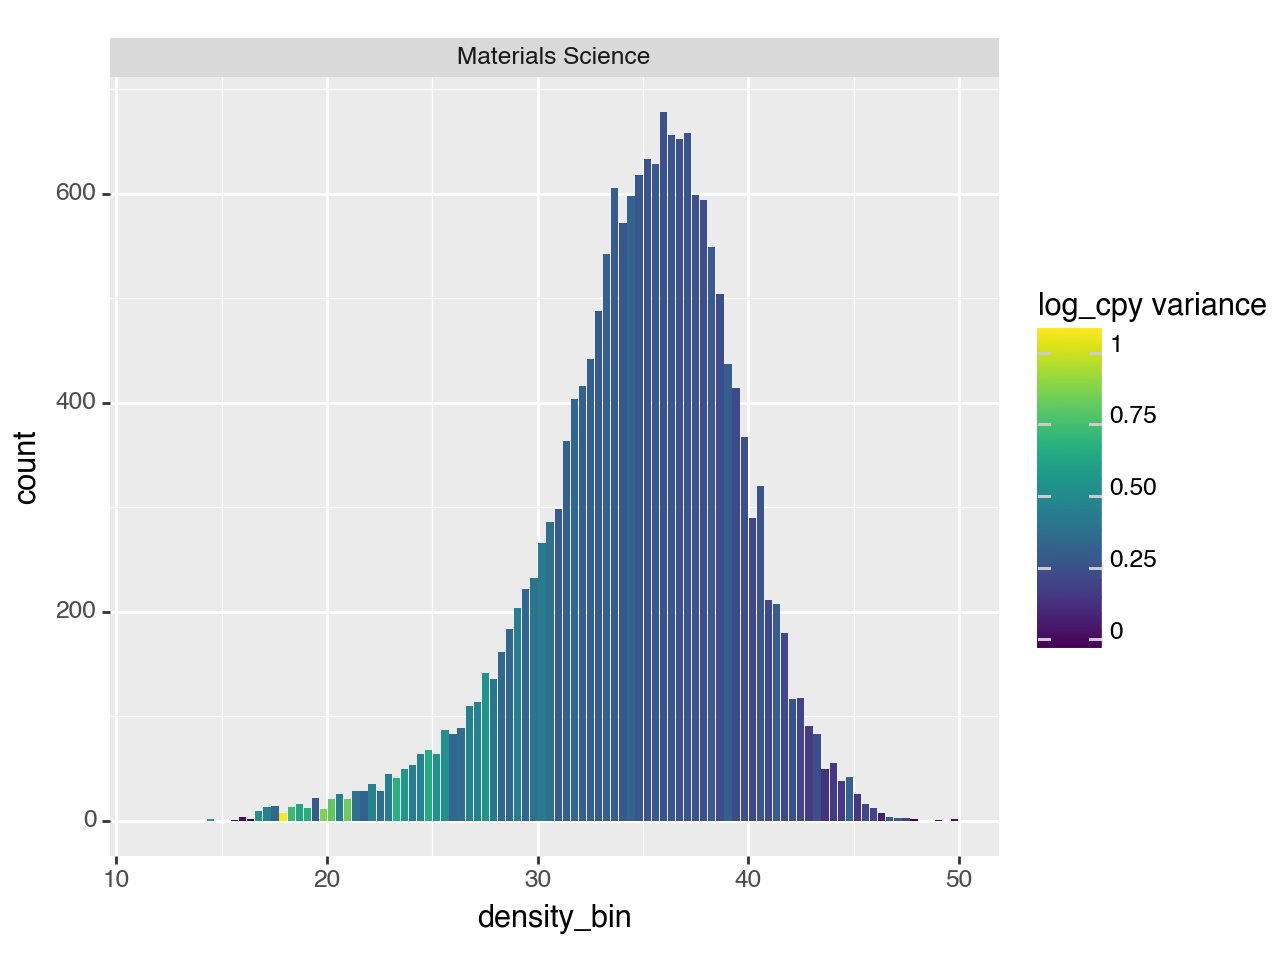

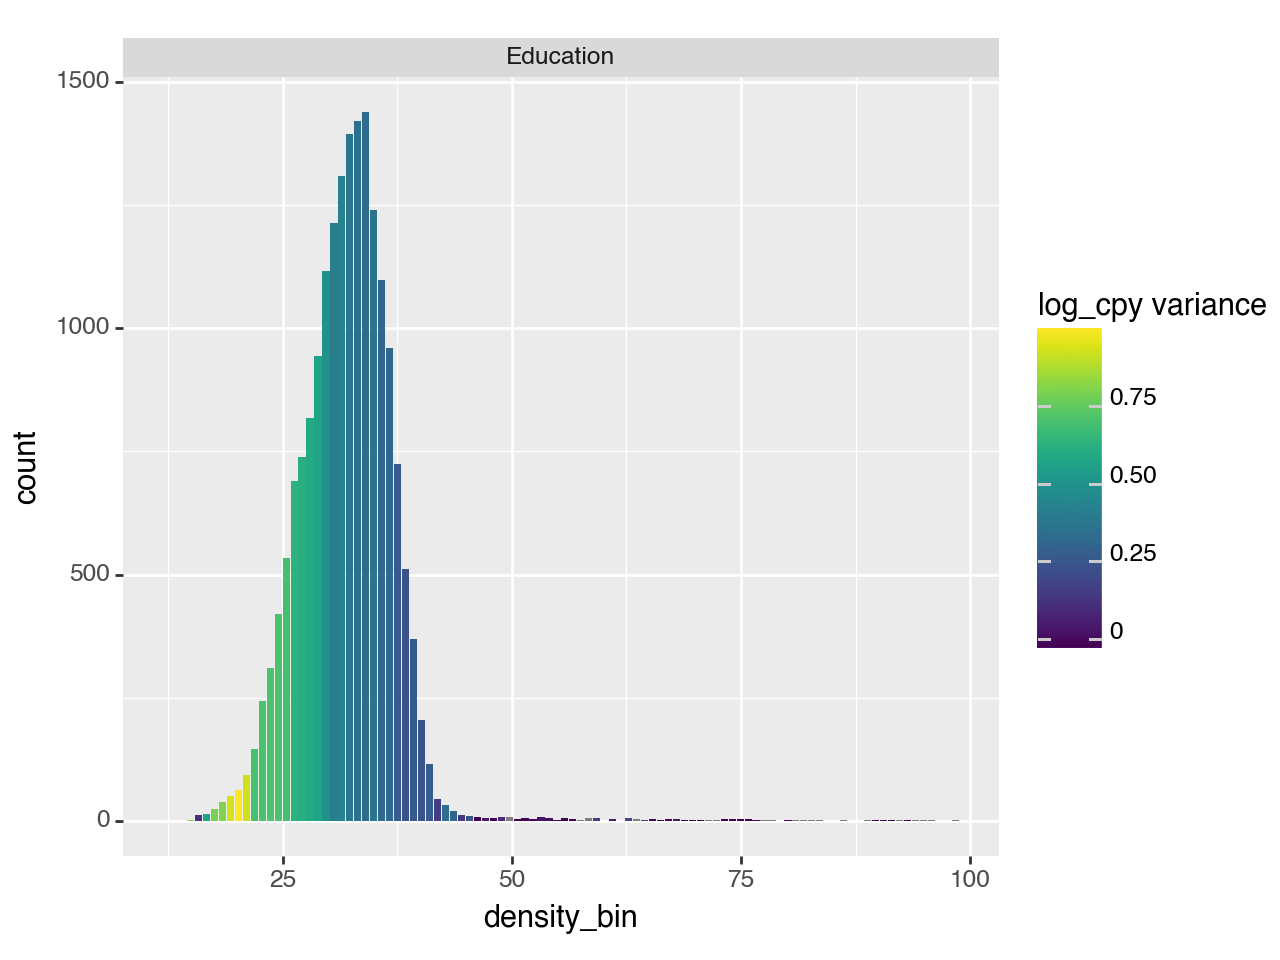

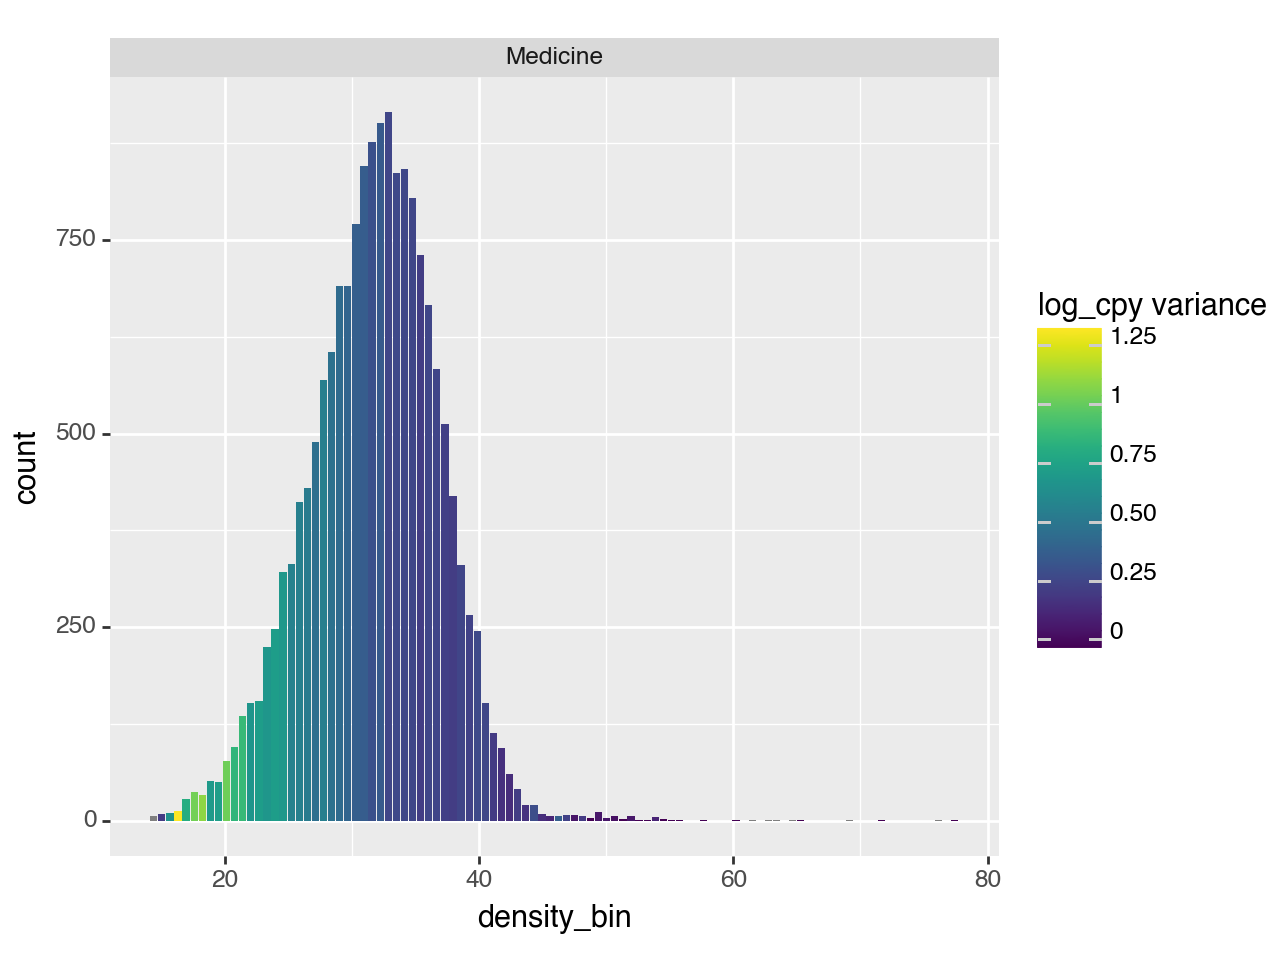

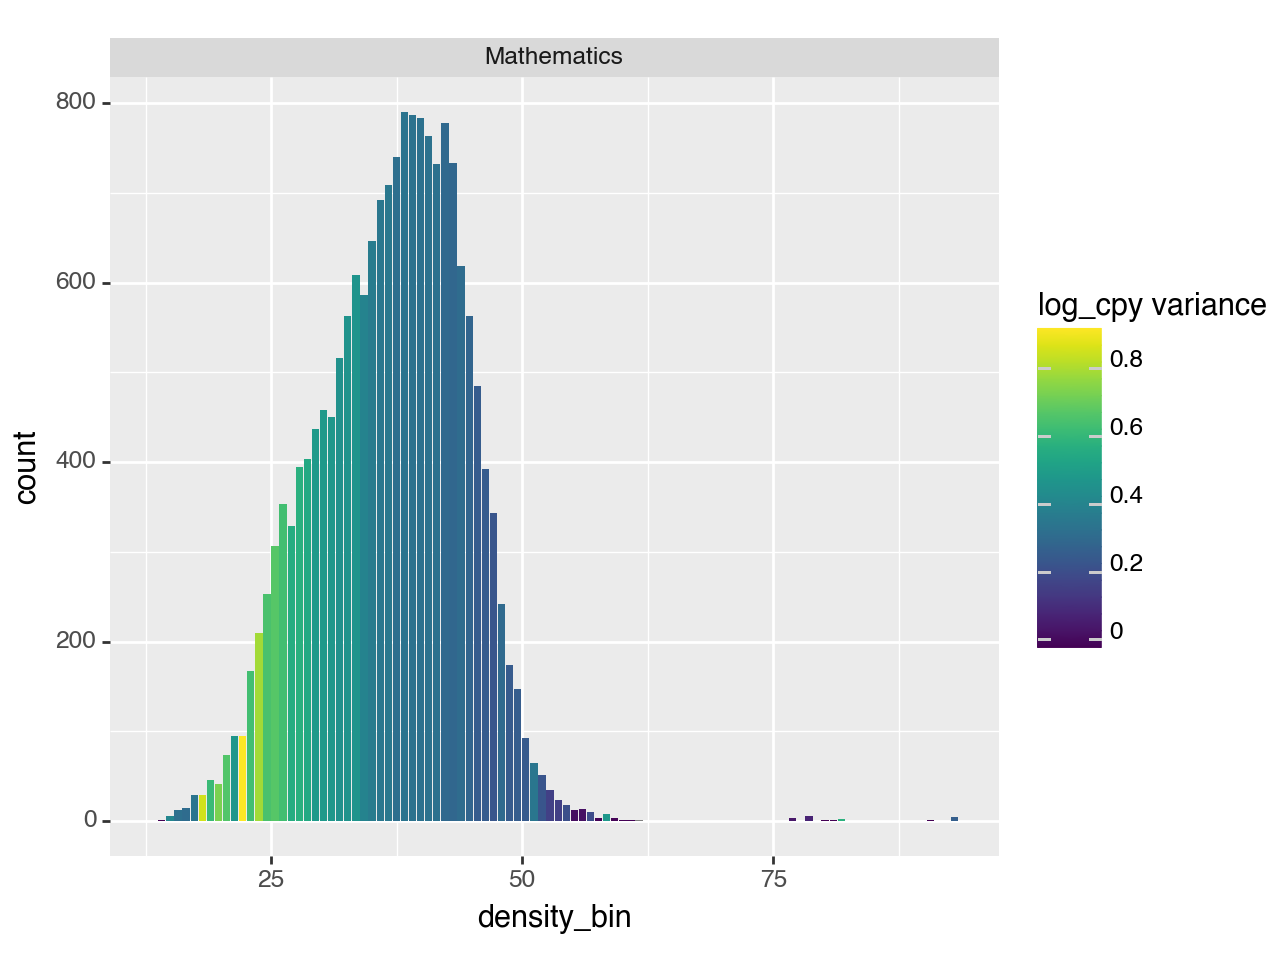

In [103]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            fill="log_cpy variance",
            y="count",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
    )


In [40]:
df_ent_all["log_cpy_variance"] = df_ent_all["log_cpy variance"]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/cit

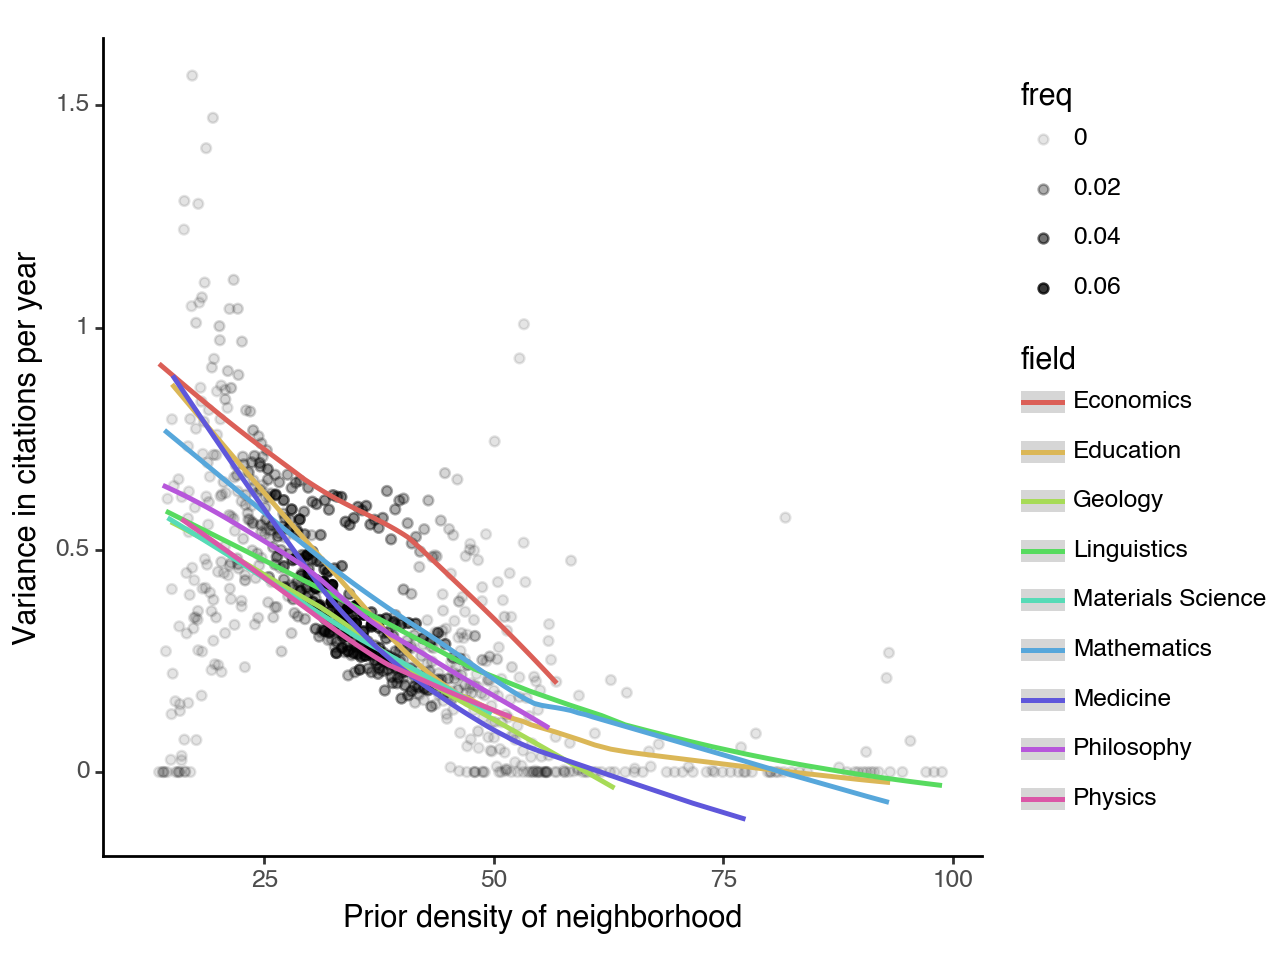

<Figure Size: (640 x 480)>

In [41]:
from scipy.stats import linregress

(
        pn.ggplot(
            df_ent_all, 
            pn.aes(
                x="density_bin",
                y="log_cpy variance",
                # color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                # size="freq",
                alpha="freq",                            
            )
        )
        + pn.geom_smooth(
            pn.aes(
                color="field",
            )
        )
        + pn.ylab("Variance in citations per year")
        + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
)

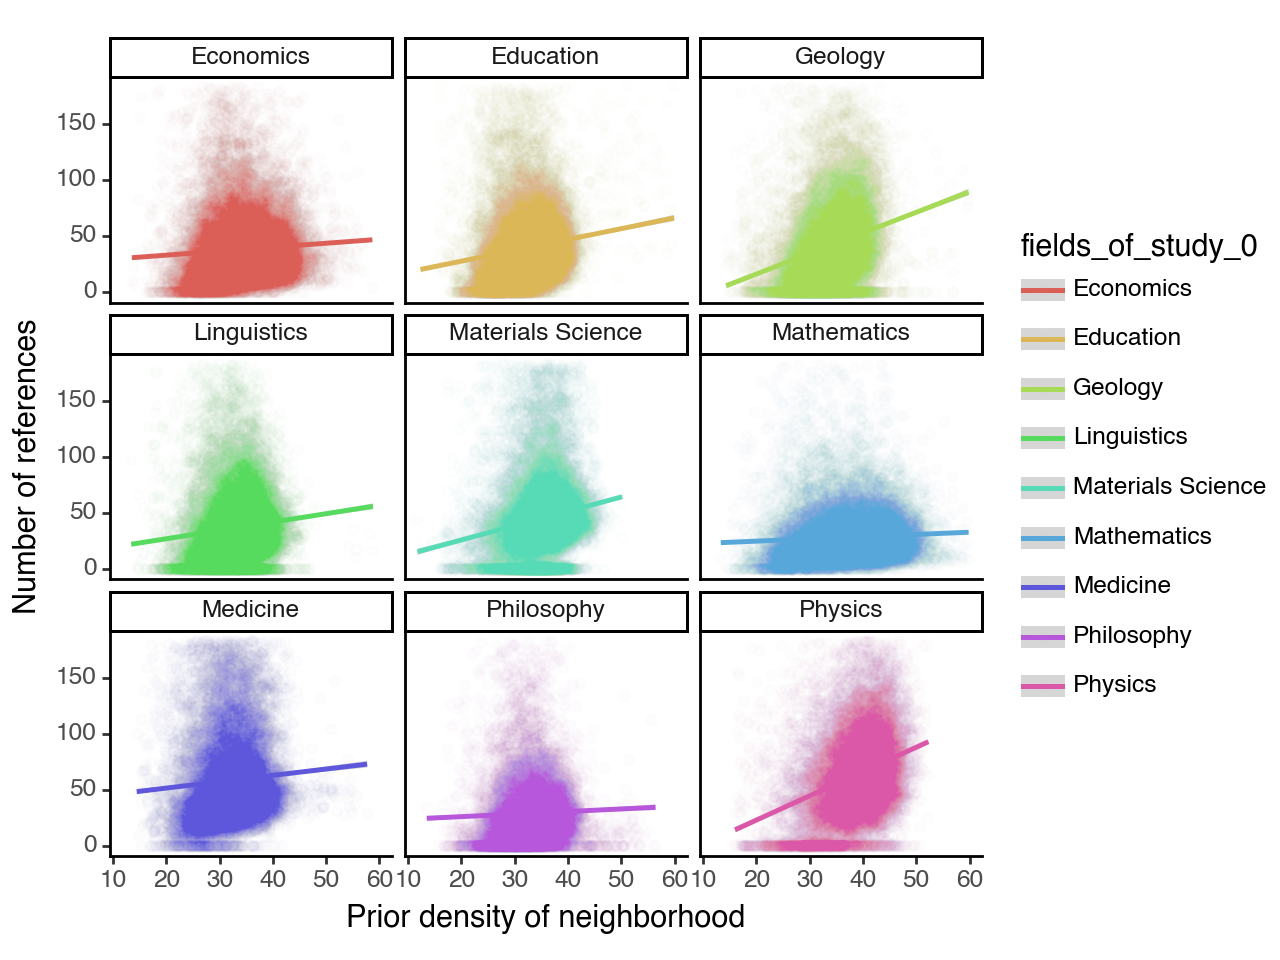

<Figure Size: (640 x 480)>

In [ ]:
# Let's visualize reference length for all fields.

df_temp =  df[df["density"] < 60]
df_temp = df_temp[df_temp.references < (df_temp.references.mean())+2*df_temp.references.std()]

(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.xlab("Prior density of neighborhood")
    + pn.ylab("Number of references")
    + pn.theme_classic()
    # TODO: annotate each line with R^2, p-values
    # TODO: normalize each by the average number of references per field
)

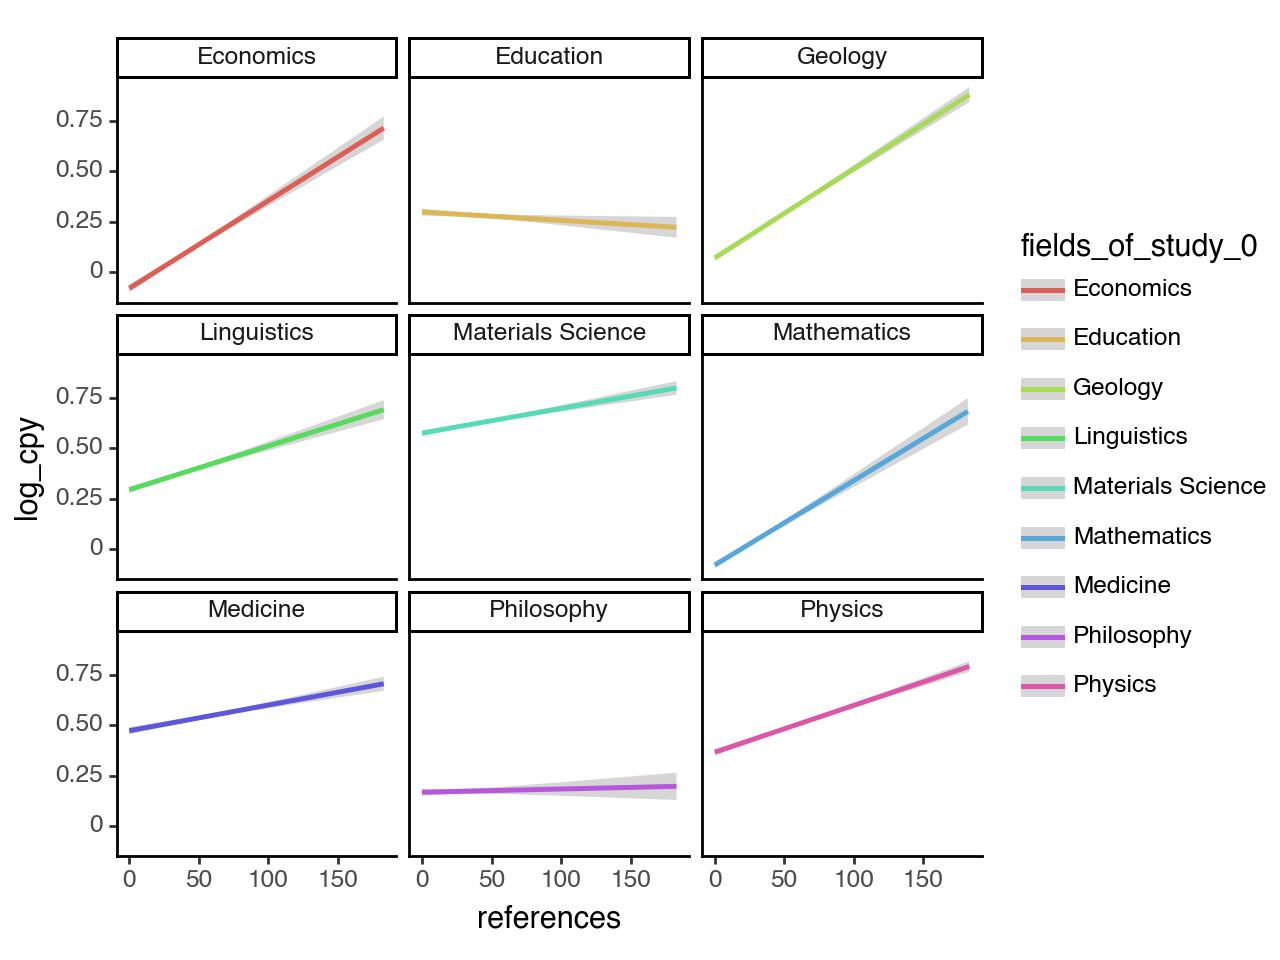

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="references",
            y="log_cpy",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    # + pn.geom_point(alpha=0.01)
    # + pn.geom_hline( pn.aes(yintercept=df_temp.log_cpy.median().item()) )
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

In [ ]:
# try in R, maybe its prettier.
df_ent_all.to_csv("all_cpy_variance_data.csv", index=False)